In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

# 1 - Loading the data

In [85]:
file_path = '../data/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
header    = ['Sample code number', 'Clump Thickness', 'Uniformity of Cell Size',
             'Uniformity of Cell Shape', 'Marginal Adhesion','Single Epithelial Cell Size',
             'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']
raw_data  = pd.read_csv(file_path, names=header)
raw_data.head(5)

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


# 2 - Cleaning the data

For this particular dataset, the cleaning steps will consist of:

1. Flagging and deleting rows containing missing values, if any
2. Flagging each cell that is not a float 
3. Flagging and deleting duplicate rows, if any
4. Flagging and flagging outliers in the data
5. Flagging data outside the range specified by the file description [0-10]
6. Deleting flagged errors

The different flags will be:

- 'ok' (no issue found with row)
- 'not a float'
- 'duplicate'
- 'out of range'
- 'potential outlier'

In [86]:
# Add a flag column to the pandas dataset, will be used to flag potential problems in the data
raw_data['flag'] = 'ok' # by default, flag everything as OK, this may change as problems are found
raw_data.head(5)

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,flag
0,1000025,5,1,1,1,2,1,3,1,1,2,ok
1,1002945,5,4,4,5,7,10,3,2,1,2,ok
2,1015425,3,1,1,1,2,2,3,1,1,2,ok
3,1016277,6,8,8,1,3,4,3,7,1,2,ok
4,1017023,4,1,1,3,2,1,3,1,1,2,ok


In [87]:
columns_to_clean = [c for c in raw_data.columns if c not in ['flag', 'Sample code number']]
print(columns_to_clean)

['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']


### 1 - Flag missing values

In [88]:
def flag_missing(df):
    print(df.isna().sum())
    
flag_missing(raw_data)

Sample code number             0
Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
flag                           0
dtype: int64


As we can see above, there are no NaN values in the red wine dataframe. We can move to the next step.

### 2 - Make sure every cell is numeric

Here we have to check delete the columns that contain non-float values before we can proceed to out of range and outlier detection

In [89]:
def isFloat(string):
    try:
        float(string)
        return True
    except ValueError:
        return False
    
def flag_not_float(df, column):
    for i in df.index:
        if not isFloat(df[column][i]):
            df.at[i, 'flag'] = 'not a float'
    return df

# Test that all columns are made of float values
for column in columns_to_clean:
    raw_data = flag_not_float(raw_data, column)
    
raw_data[raw_data['flag'] == 'not a float'].head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,flag
23,1057013,8,4,5,1,2,?,7,3,1,4,not a float
40,1096800,6,6,6,9,6,?,7,8,1,2,not a float
139,1183246,1,1,1,1,1,?,2,1,1,2,not a float
145,1184840,1,1,3,1,2,?,2,1,1,2,not a float
158,1193683,1,1,2,1,3,?,1,1,1,2,not a float


Deleting rows containing values that are not floats

In [90]:
raw_data = raw_data[raw_data['flag'] != 'not a float']

for column in columns_to_clean:
    raw_data[column] = pd.to_numeric(raw_data[column],errors='coerce')
    
raw_data.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,flag
0,1000025,5,1,1,1,2,1,3,1,1,2,ok
1,1002945,5,4,4,5,7,10,3,2,1,2,ok
2,1015425,3,1,1,1,2,2,3,1,1,2,ok
3,1016277,6,8,8,1,3,4,3,7,1,2,ok
4,1017023,4,1,1,3,2,1,3,1,1,2,ok


Making sure everything was converted without error

In [91]:
raw_data.isnull().sum()

Sample code number             0
Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
flag                           0
dtype: int64

### 3 - Checking for out of range data

In [92]:
def flag_out_of_range(df):
    
    for col_name in columns_to_clean:
        out_of_ranges = df[(df[col_name] < 0) | (df[col_name] > 10)] 
        for i in out_of_ranges.index:
            df.at[i, 'flag'] = 'out of range'
    return df
    

# For the 'out of range' check we have to delete the 'not a float' rows 
raw_data = flag_out_of_range(raw_data)
print("There are %s rows with out of range data" % len(raw_data[raw_data['flag'] == 'out of range'].index))

There are 0 rows with out of range data


### 3 - Identify potential duplicate rows

In [94]:
def flag_duplicates(df):
    
    duplicate_rows_df = df[df.duplicated()]
    if duplicate_rows_df.shape[0] == 0:
        print("No duplicates found in dataframe")
        return raw_data
    
    # If we reach this part of the function then we do have duplicates in the data
    print("Number of duplicate rows = %s" % duplicate_rows_df.shape[0])
    for i in duplicate_rows_df.index:
        raw_data.at[i, 'flag'] = 'duplicate'
    return raw_data
    

raw_data = flag_duplicates(raw_data)
raw_data.head()

No duplicates found in dataframe


,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,flag
0,1000025,5,1,1,1,2,1,3,1,1,2,ok
1,1002945,5,4,4,5,7,10,3,2,1,2,ok
2,1015425,3,1,1,1,2,2,3,1,1,2,ok
3,1016277,6,8,8,1,3,4,3,7,1,2,ok
4,1017023,4,1,1,3,2,1,3,1,1,2,ok


### 4 - Flag outlier data

First we can plot the boxplots to see how each variable is represented in the dataset. Then, assuming the distributions are Gaussian, one could flag as an outlier any value that falls outside of 3 standard deviations from the mean. Since we don't know if the Gaussian assumption holds, we will run the models with different versions of the dataset to determine whether outlier flagging helped improve the predictions.

1. after deleting the duplicate rows only, and 
2. after deleting the duplicate rows *as well as* what we have considered to be outlier values

To evaluate which version performs best.

**Boxplots**

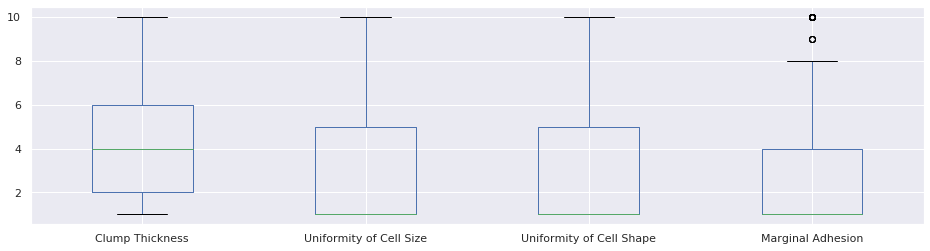

In [95]:
def draw_boxplots(raw_data, columns_to_clean):
    plt.figure(figsize=(16, 4))
    raw_data[columns_to_clean].boxplot()
    plt.show()

# Sulfur variables have much higher values than the rest, so we seperated them
list1 = ['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion']
other_vars  = [v for v in columns_to_clean if not v in list1]

draw_boxplots(raw_data, list1)

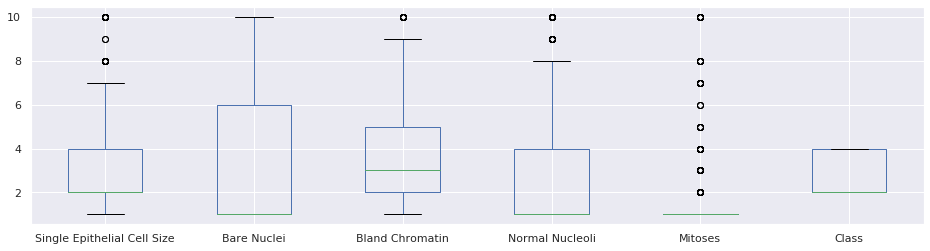

In [96]:
draw_boxplots(raw_data, other_vars)

As we see above, the 'Mitoses' class has significant outliers.

**Flag potential outliers**

In [98]:
def flag_outliers(df, columns_to_clean, n_std=3):
    """
    n_std: number of standard deviations above which a value is considered to be an outlier
    If a given row will be flagged if it contains at least one outlier
    """
    
    for col in columns_to_clean:
        # sumamry statistics
        col_mean, col_std = np.mean(df[col]), np.std(df[col])
        # identify outliers
        cut_off = col_std * n_std
        # this is the range of acceptable data
        lower, upper = col_mean - cut_off, col_mean + cut_off
        
        # outliers
        outliers = df[(df[col]<lower) | (df[col]>upper)]
        for i in outliers.index:
            df.at[i, 'flag'] = 'potential outlier'    
    return df
    
raw_data = flag_outliers(raw_data, columns_to_clean)

### 5 - Delete flagged data

Summary of the flagging : we have 223 duplicates and 148 rows containing at least one outlier value.

In [103]:
summary = raw_data.groupby('flag').count()['Class']
summary

flag
duplicate              7
ok                   625
potential outlier     51
Name: Class, dtype: int64

Cleanup

In [104]:
raw_data.head(5)

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,flag
0,1000025,5,1,1,1,2,1,3,1,1,2,ok
1,1002945,5,4,4,5,7,10,3,2,1,2,ok
2,1015425,3,1,1,1,2,2,3,1,1,2,ok
3,1016277,6,8,8,1,3,4,3,7,1,2,ok
4,1017023,4,1,1,3,2,1,3,1,1,2,ok


In [106]:
def get_clean_dataframe(df, delete_outliers=False):
    """
    The 'delete_outliers' attribute can be set to True to also remove rows flagged as outliers
    """
    if delete_outliers is True:
        clean_data = df[df['flag']=='ok']
    else:
        clean_data = df[(df['flag']=='ok') | (df['flag']=='potential outlier')]
    # Drop the flag column before returning the clean data
    return clean_data.drop('flag', axis=1)
    

# Get the clean data
clean_df   = get_clean_dataframe(raw_data) # this is to skip SettingWithCopyWarning from Pandas
clean_data = clean_df.copy()
# Create the binary y column
clean_data['y'] = np.where(clean_df['Class'] == 4.0, 1.0, 0.0)
clean_data.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,y
0,1000025,5,1,1,1,2,1,3,1,1,2,0.0
1,1002945,5,4,4,5,7,10,3,2,1,2,0.0
2,1015425,3,1,1,1,2,2,3,1,1,2,0.0
3,1016277,6,8,8,1,3,4,3,7,1,2,0.0
4,1017023,4,1,1,3,2,1,3,1,1,2,0.0


# 3 - Exploratory data analysis

This section includes:

1. Histograms of each variable
2. Scatterplots (xi,y) 
3. The new boxplots 

In [107]:
y_vars = ['Class', 'y']
x_vars = [var for var in clean_data.columns.tolist() if not var in y_vars]

print(x_vars)
print(y_vars)

['Sample code number', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses']
['Class', 'y']


## 1 - Histograms

### Input variables

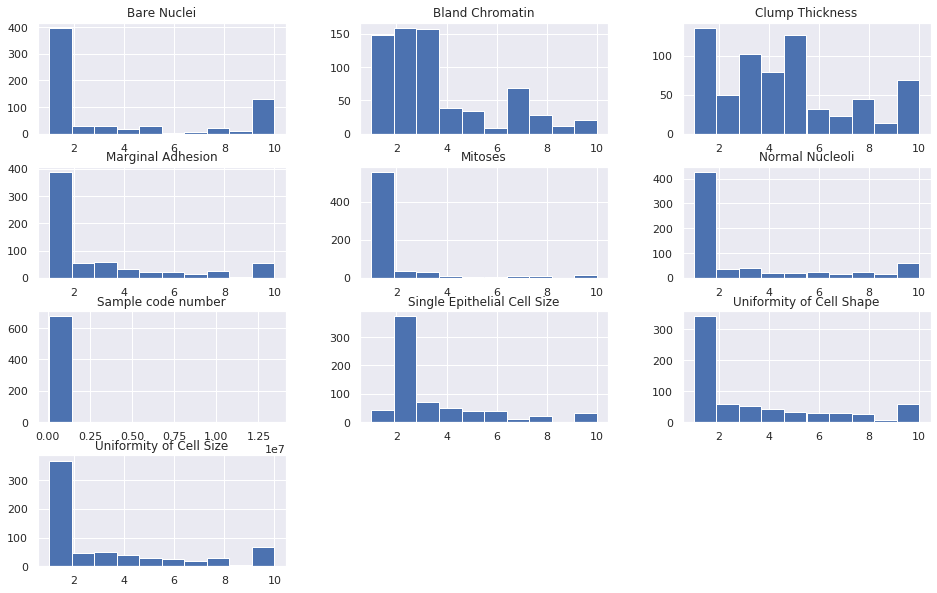

In [109]:
def draw_histogram(df, bins=50, width=12, height=5):
    df.hist(bins=bins, figsize=(width,height))
    
draw_histogram(clean_data[x_vars], bins=10, width=16, height=10)

### Outputs variables

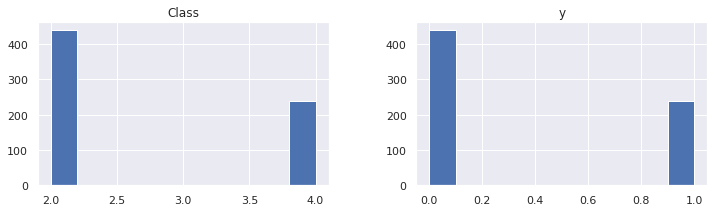

In [110]:
draw_histogram(clean_data[y_vars], bins=10, width=12, height=3)

## 2 - Distribution of the input variables, by quality category

In [130]:
def plot_dist_by_category(df, x, y_cat):
    
    fig = plt.figure(figsize=(16,4))
    
    #------------------------------------------------------------
    # P(Xi|Y=0) versus P(Xi|Y=1)
    #------------------------------------------------------------
    pos_class = df[df[y_cat] == 1.0] # positive class 
    neg_class = df[df[y_cat] == 0.0] # negative class
    
    pos_mean = float(np.mean(pos_class[[x]])) # mean, positive class
    neg_mean = float(np.mean(neg_class[[x]])) # mean, negative class
    
    sns.distplot(pos_class[[x]], norm_hist=True, color='#7282ff')
    sns.distplot(neg_class[[x]], norm_hist=True, color='#e56666')
    
    plt.axvline(pos_mean, color='#7282ff')
    plt.axvline(neg_mean, color='#e56666')
    
    fig.legend(labels=['%s for y=1' % x,'%s for y=0' % x], loc='upper center')
    
    
var_list = clean_data.columns.tolist()
print(var_list)

['Sample code number', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class', 'y']


### Clump Thickness


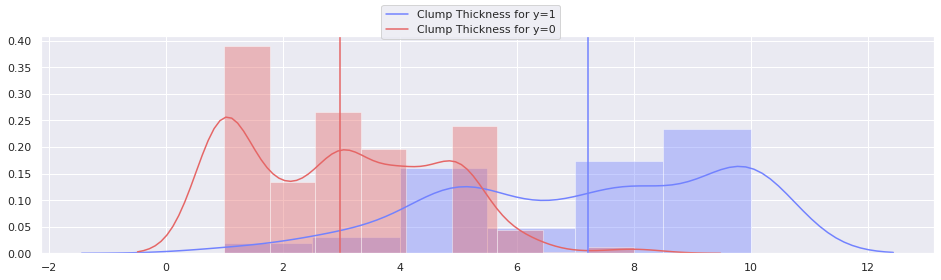

In [131]:
plot_dist_by_category(clean_data, 'Clump Thickness', 'y')    

### Uniformity of Cell Size

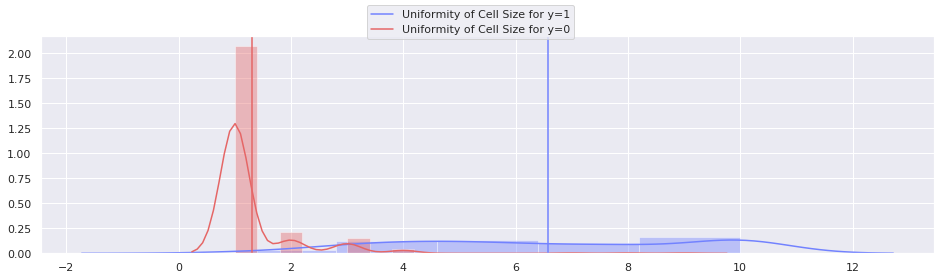

In [132]:
plot_dist_by_category(clean_data, 'Uniformity of Cell Size', 'y')

### Uniformity of Cell Shape

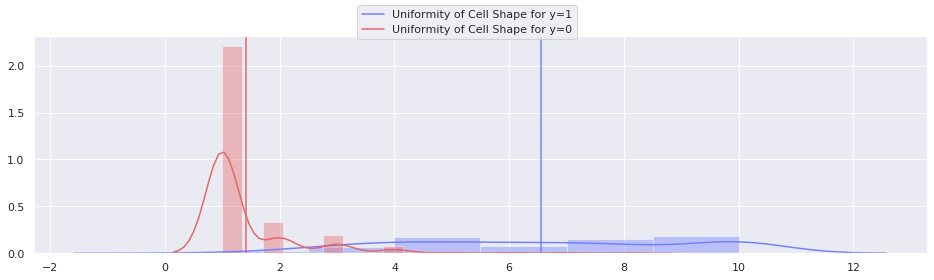

In [133]:
plot_dist_by_category(clean_data, 'Uniformity of Cell Shape', 'y')

### Marginal Adhesion

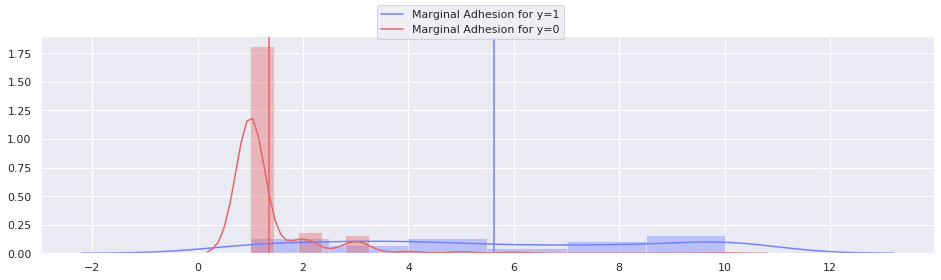

In [134]:
plot_dist_by_category(clean_data, 'Marginal Adhesion', 'y')

### Single Epithelial Cell Size

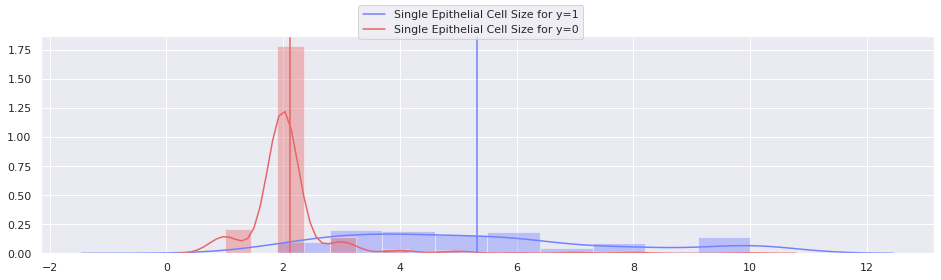

In [135]:
plot_dist_by_category(clean_data, 'Single Epithelial Cell Size', 'y')

### Bare Nuclei

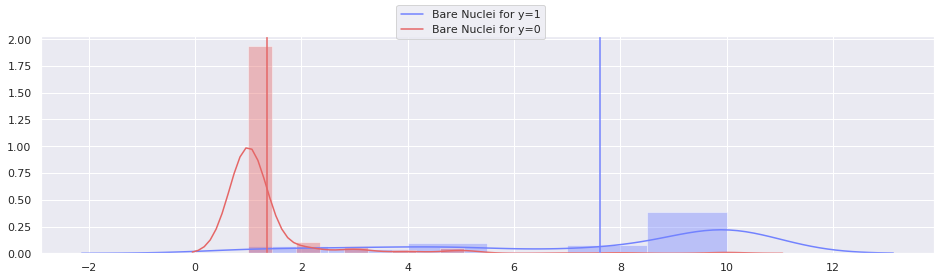

In [136]:
plot_dist_by_category(clean_data, 'Bare Nuclei', 'y')

### Bland Chromatin

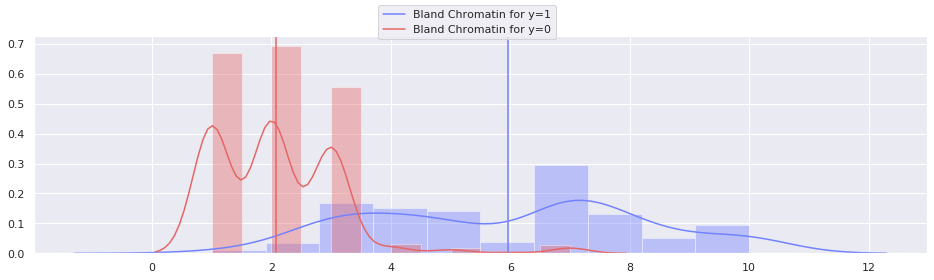

In [137]:
plot_dist_by_category(clean_data, 'Bland Chromatin', 'y')

### Normal Nucleoli

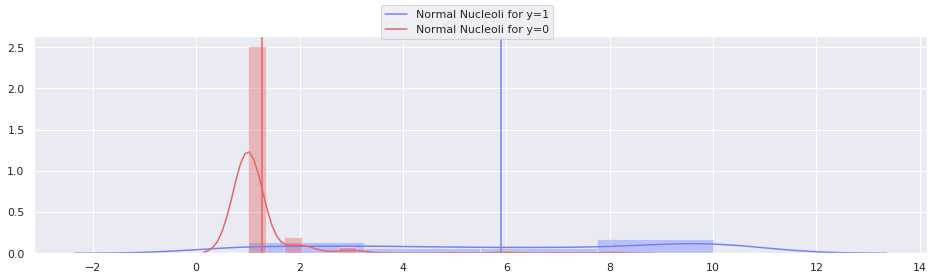

In [138]:
plot_dist_by_category(clean_data, 'Normal Nucleoli', 'y')

### Mitoses

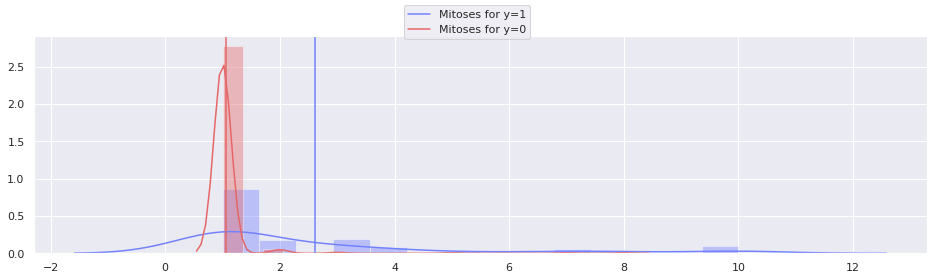

In [139]:
plot_dist_by_category(clean_data, 'Mitoses', 'y')

## 3 - Correlation analysis

In [140]:
corr = clean_data[x_vars + ['y']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,y
Sample code number,1,-0.06,-0.043,-0.042,-0.071,-0.05,-0.098,-0.062,-0.053,-0.039,-0.084
Clump Thickness,-0.06,1,0.64,0.65,0.49,0.52,0.6,0.55,0.53,0.35,0.72
Uniformity of Cell Size,-0.043,0.64,1,0.91,0.71,0.75,0.69,0.76,0.72,0.46,0.82
Uniformity of Cell Shape,-0.042,0.65,0.91,1,0.69,0.72,0.71,0.73,0.72,0.44,0.82
Marginal Adhesion,-0.071,0.49,0.71,0.69,1,0.6,0.67,0.67,0.6,0.42,0.71
Single Epithelial Cell Size,-0.05,0.52,0.75,0.72,0.6,1,0.58,0.62,0.63,0.48,0.69
Bare Nuclei,-0.098,0.6,0.69,0.71,0.67,0.58,1,0.68,0.59,0.34,0.82
Bland Chromatin,-0.062,0.55,0.76,0.73,0.67,0.62,0.68,1,0.67,0.35,0.76
Normal Nucleoli,-0.053,0.53,0.72,0.72,0.6,0.63,0.59,0.67,1,0.43,0.72
Mitoses,-0.039,0.35,0.46,0.44,0.42,0.48,0.34,0.35,0.43,1,0.42


# 4 - Turn the dataframe into a Numpy array for the rest of the project

In [141]:
def dataframe_to_narray(df, x_vars, y_var):
    
    X = df[x_vars].to_numpy()
    y = df[y_var].to_numpy()
    
    return X,y
    
X, y = dataframe_to_narray(clean_data, x_vars, 'y')

print(X)
print(y)

[[1000025       5       1 ...       3       1       1]
 [1002945       5       4 ...       3       2       1]
 [1015425       3       1 ...       3       1       1]
 ...
 [ 888820       5      10 ...       8      10       2]
 [ 897471       4       8 ...      10       6       1]
 [ 897471       4       8 ...      10       4       1]]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1.
 1. 1. 